[*********************100%%**********************]  1 of 1 completed


Date
2021-05-01    0.000000
2021-05-02   -0.020699
2021-05-03    0.010051
2021-05-04   -0.067600
2021-05-05    0.076696
                ...   
2024-02-01    0.011581
2024-02-02    0.002556
2024-02-03   -0.004483
2024-02-04   -0.009506
2024-02-06    0.000114
Name: Adj Close, Length: 1011, dtype: float64


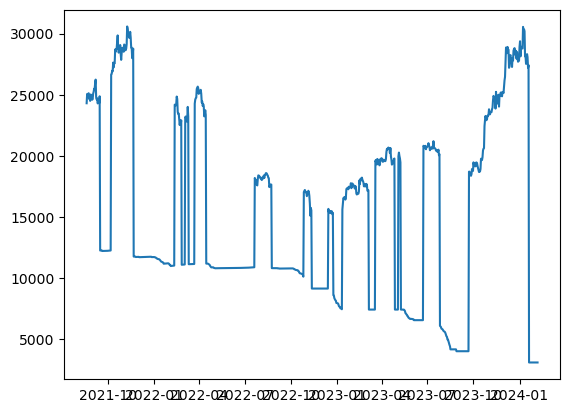

cash_daily_vol_targ : 251.9763153394848


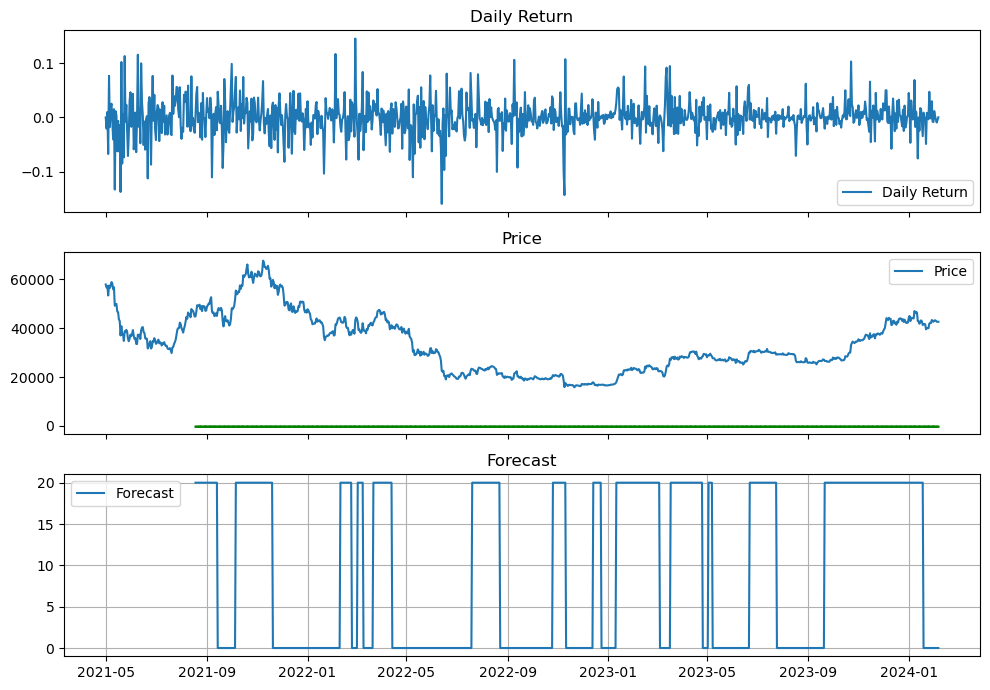

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from vol import robust_vol_cal

In [2]:
import yfinance as yf

In [681]:
sp500 = yf.download('AAPL', start = "2015-05-01", interval= '1d')
price = sp500['Adj Close']
ret = price.pct_change().fillna(0)

np.random.seed(100)
#daily_returns = pd.Series(np.random.normal(0, 0.025, 3000), index=pd.date_range(start='2015-01-01', periods=3000))
#price = (1 + daily_returns).cumprod()

vol = robust_vol_cal(price.pct_change())
vol_f = robust_vol_cal(price.diff())
fast_ma = price.rolling(10, min_periods=10).mean()
slow_ma = price.rolling(40, min_periods=10).mean()
raw_ma = fast_ma - slow_ma
forecast = (raw_ma/vol_f).clip(lower = 0, upper = 20)

inital_cash = 20000
pct_annual_volatility_target = 0.3

cash_annual_vol_targ = inital_cash * pct_annual_volatility_target
cash_daily_vol_targ = cash_annual_vol_targ / np.sqrt(252)

block_vol = price * vol

# calculate the share needed for each day
share_needed = cash_daily_vol_targ / block_vol
cash_needed = share_needed * price

[*********************100%%**********************]  1 of 1 completed


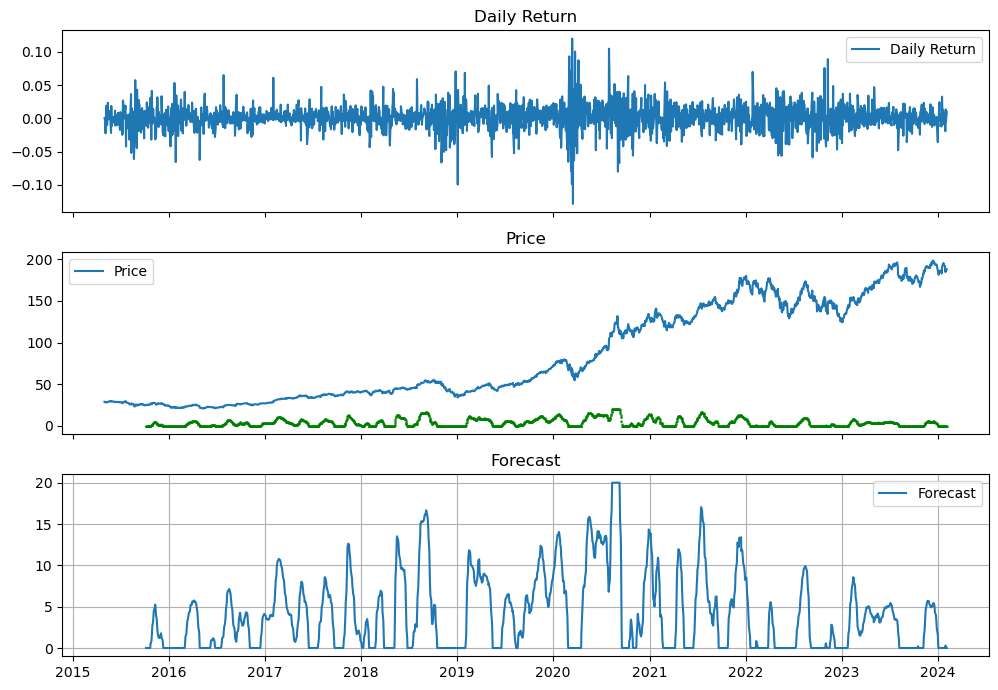

In [682]:
fig, axs = plt.subplots(3, 1, figsize=(10, 7), sharex=True)  # Enable sharing x-axis

# Plot daily return
axs[0].plot(ret, label='Daily Return')
axs[0].set_title('Daily Return')
axs[0].legend(loc='best')

# Plot price
axs[1].plot(price, label='Price')
axs[1].plot(forecast, 'g^', markersize = 1)
axs[1].set_title('Price')
axs[1].legend(loc='best')

# Plot forecast
axs[2].plot(forecast, label='Forecast')
axs[2].set_title('Forecast')
axs[2].legend(loc='best')

# Improve layout and display the figure
plt.grid()
plt.tight_layout()
plt.show()

In [683]:
share_needed = share_needed.fillna(0)
cash_needed = cash_needed.fillna(0)
cash_position = [20000]
asset_position = [0]
#share_needed = share_needed.shift()
#cash_needed = cash_needed.shift()
forecast = forecast.shift(1).fillna(0)  # Ensure forecast is shifted appropriately
i = 1
while i < len(price):
    # Assume decisions are based on forecast information up to day i-1
    adjustment_factor = forecast.iloc[i-1] / 10
    share_change = share_needed.iloc[i] - share_needed.iloc[i-1]
    asset_adjustment = cash_needed.iloc[i-1]  * adjustment_factor# Use cash_needed from previous day
    cost = abs(share_change) * 0.0005
    if asset_adjustment > cash_position[i-1]:
        port = cash_position[i-1] * (1 + ret.iloc[i-1])
        port -= cost
        cash_position.append(port)
    else:
        cash = cash_position[i-1] - asset_adjustment
        # Asset's value adjustment based on yesterday's return, realized today
        asset_value_today = asset_adjustment * (1 + ret.iloc[i-1])
        cash += asset_value_today  # Update cash with realized asset value
        cash -= cost
        cash_position.append(cash)
    i += 1

    

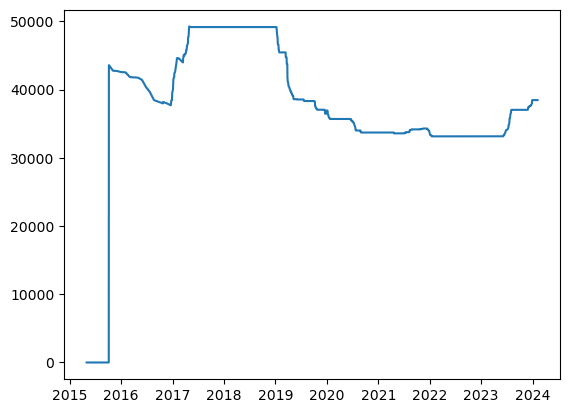

In [684]:
plt.plot(cash_needed)

In [685]:
# generate buy and hold

buy_and_hold = (20000 * (1 + ret).cumprod())

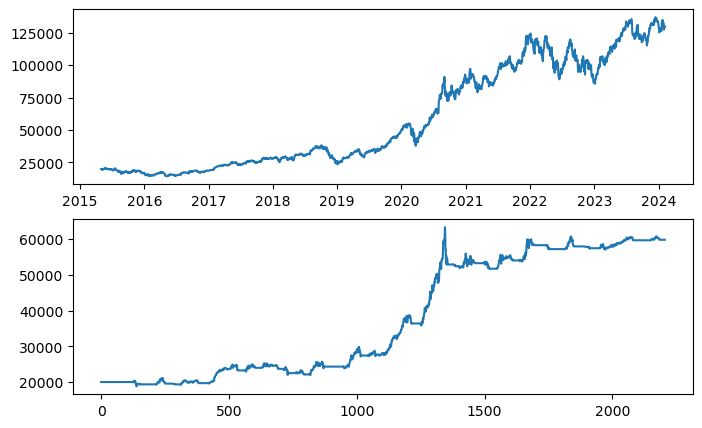

In [686]:
fig, axs = plt.subplots(2, 1, figsize = (8, 5))


axs[0].plot(buy_and_hold)
axs[1].plot(cash_position)

In [687]:
s = pd.Series(cash_position)

# Calculate daily returns and filter out days with no change
s_ret = s.pct_change().fillna(0)
non_zero_returns = s_ret[s_ret != 0]

# Calculate and print the skewness of non-zero returns
skewness = non_zero_returns.skew()
print(f"Skewness of non-zero returns: {skewness}")

Skewness of non-zero returns: -0.2562592134211459


In [688]:
buy_and_hold.pct_change().fillna(0).skew()

-0.030327016703130972

In [689]:
# BUY AND HOLD SHARPE
daily_returns = buy_and_hold.pct_change().fillna(0)

# Calculate cumulative return
cumulative_return = (1 + daily_returns).cumprod().iloc[-1] - 1

# Calculate the number of years the investment was held
n_years = (buy_and_hold.index[-1] - buy_and_hold.index[0]).days / 252

# Calculate annualized return
annualized_return = (1 + cumulative_return) ** (1 / n_years) - 1

std_dev_daily = daily_returns.std()

# Annualize the volatility
annualized_volatility = std_dev_daily * np.sqrt(252)

sharpe_buy_and_hold = annualized_return/annualized_volatility
sharpe_buy_and_hold

0.5448007926588169

In [690]:
daily_returns = s.pct_change().fillna(0)

# Calculate cumulative return
cumulative_return = (1 + daily_returns).cumprod().iloc[-1] - 1

# Calculate the number of years the investment was held
n_years = (s.index[-1] - s.index[0]) / 252

# Calculate annualized return
annualized_return = (1 + cumulative_return) ** (1 / n_years) - 1

std_dev_daily = daily_returns.std()

# Annualize the volatility
annualized_volatility = std_dev_daily * np.sqrt(252)

sharpe_s = annualized_return/annualized_volatility
sharpe_s

1.0435174784523342